# Quantum Teleportation Protocol

In [13]:
%pip install qiskit==1.4.2 qiskit-aer==0.16.1

%pip install matplotlib pylatexenc # For visualization

from IPython.display import clear_output
clear_output()

In [14]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from numpy import pi, random

Here is a quantum circuit implementation of the teleportation protocol.

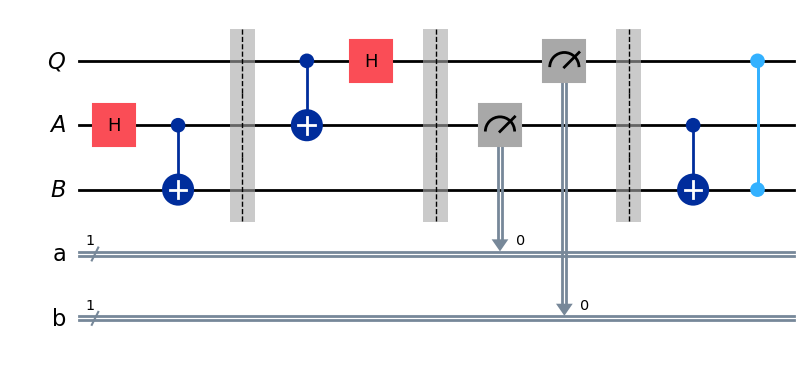

In [15]:
qubit = QuantumRegister(1, "Q")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")
a = ClassicalRegister(1, "a")
b = ClassicalRegister(1, "b")

protocol = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Prepare ebit used for teleportation
protocol.h(ebit0)
protocol.cx(ebit0, ebit1)
protocol.barrier()

# Alice's operations
protocol.cx(qubit, ebit0)
protocol.h(qubit)
protocol.barrier()

# Alice measures and sends classical bits to Bob
protocol.measure(ebit0, a)
protocol.measure(qubit, b)
protocol.barrier()

# Bob uses the classical bits to conditionally apply gates
protocol.cx(ebit0, ebit1) 
protocol.cz(qubit, ebit1) # CZ is symmetrical

display(protocol.draw(output="mpl"))

The *if_test* function applies an operation conditionally depending on a classical bit or register.

The circuit first initializes 
$(A,B)$ to be in a $\ket{\phi^+}$ state (which is not part of the protocol itself), followed by Alice's operations, then her measurements, and finally Bob's operations. To test that the protocol works correctly, we'll apply a randomly generated single-qubit gate to the initialized $\ket{0}$ state of $Q$ to obtain a random quantum state vector to be teleported. By applying the inverse (i.e., conjugate transpose) of that gate to $B$ after the protocol is run, we can verify that the state was teleported by measuring to see that it has returned to the $\ket{0}$ state.

First let's randomly choose a unitary qubit gate.

In [16]:
random_gate = UGate(
    theta=random.random() * 2 * pi,
    phi=random.random() * 2 * pi,
    lam=random.random() * 2 * pi
)

display(array_to_latex(random_gate.to_matrix()))

<IPython.core.display.Latex object>

Now we'll create a new testing circuit that first applies our random gate to $Q$, then runs the teleportation circuit, and finally applies the inverse of our random gate to the qubit $B$ and measures. The outcome should be $0$ with certainty.

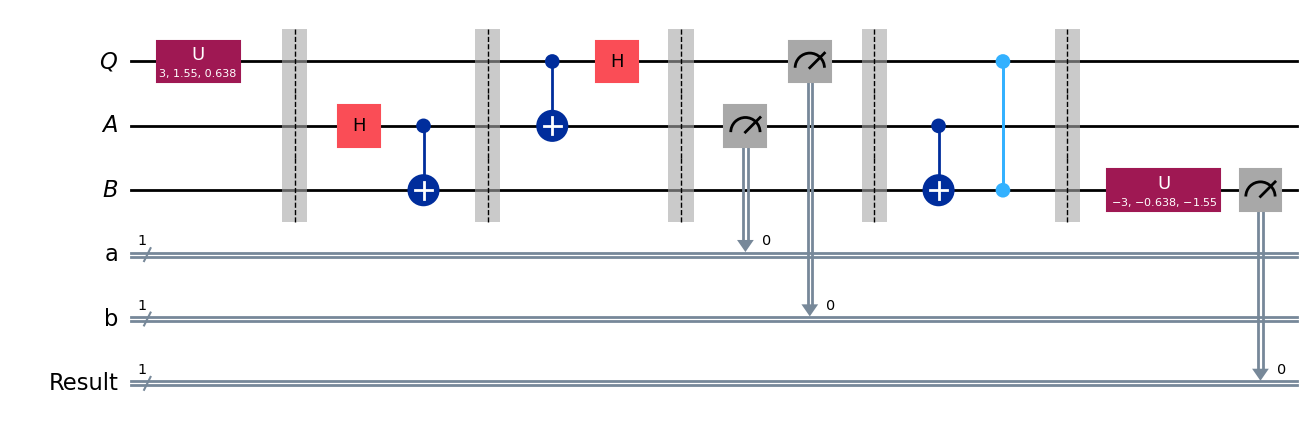

In [17]:
# Create a new circuit including the same bits and qubits used in the
# teleportation protocol.

teleportation_test = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Start with the randomly selected gate on Q

teleportation_test.append(random_gate, qubit)
teleportation_test.barrier()

# Append the entire teleportation protocol from above.

teleportation_test = teleportation_test.compose(protocol)
teleportation_test.barrier()

# Finally, apply the inverse of the random unitary to B and measure.

teleportation_test.append(random_gate.inverse(), ebit1)
result = ClassicalRegister(1, "Result")
teleportation_test.add_register(result)
teleportation_test.measure(ebit1, result)

display(teleportation_test.draw(output="mpl"))

Finally, let's run the Aer simulator on this circuit and plot a histogram of the outputs. We'll see the statistics for all three classical bits: the bottom/leftmost bit should always be $0$, indicating that the qubit $Q$ was successfully teleported into $B$, while the other two bits should be roughly uniform.

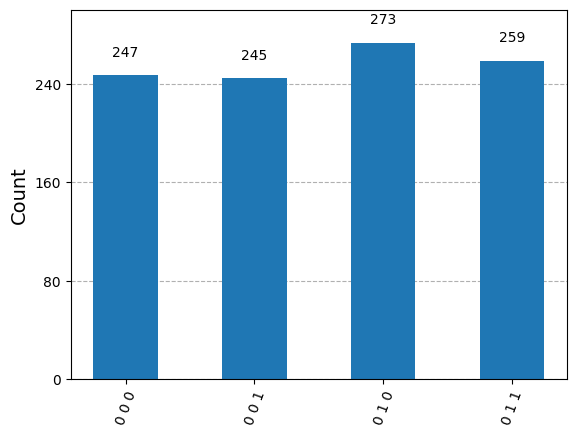

In [18]:
result = AerSimulator().run(teleportation_test).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

We can also filter the statistics to focus just on the test result qubit if we wish, like this:

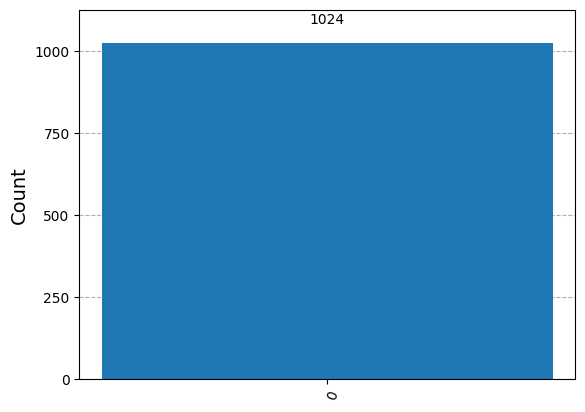

In [19]:
filtered_statistics = marginal_distribution(statistics, [2])
display(plot_histogram(filtered_statistics))

# Superdense Coding Protocol

let's use an additional qubit as a random bit generator — essentially to flip fair coins. We'll use it to randomly choose $c$ and $d$, and then run the superdense coding protocol.

In [20]:
# rbg = QuantumRegister(1, "coin")
# ebit0 = QuantumRegister(1, "A")
# ebit1 = QuantumRegister(1, "B")

# Alice_c = ClassicalRegister(1, "Alice c")
# Alice_d = ClassicalRegister(1, "Alice d")

# test = QuantumCircuit(rbg, ebit0, ebit1, Alice_d, Alice_c)

# # Initialize the ebit
# test.h(ebit0)
# test.cx(ebit0, ebit1)
# test.barrier()

# # Use the 'coin' qubit twice to generate Alice's bits c and d.
# test.h(rbg)
# test.measure(rbg, Alice_c)
# test.h(rbg)
# test.measure(rbg, Alice_d)
# test.barrier()

# # Now the protocol runs, starting with Alice's actions, which depend
# # on her bits.
# with test.if_test((Alice_d, 1), label="Z"):
#     test.z(ebit0)
# with test.if_test((Alice_c, 1), label="X"):
#     test.x(ebit0)
# test.barrier()

# # Bob's actions
# test.cx(ebit0, ebit1)
# test.h(ebit0)
# test.barrier()

# Bob_c = ClassicalRegister(1, "Bob c")
# Bob_d = ClassicalRegister(1, "Bob d")
# test.add_register(Bob_d)
# test.add_register(Bob_c)
# test.measure(ebit0, Bob_d)
# test.measure(ebit1, Bob_c)

# display(test.draw(output="mpl"))

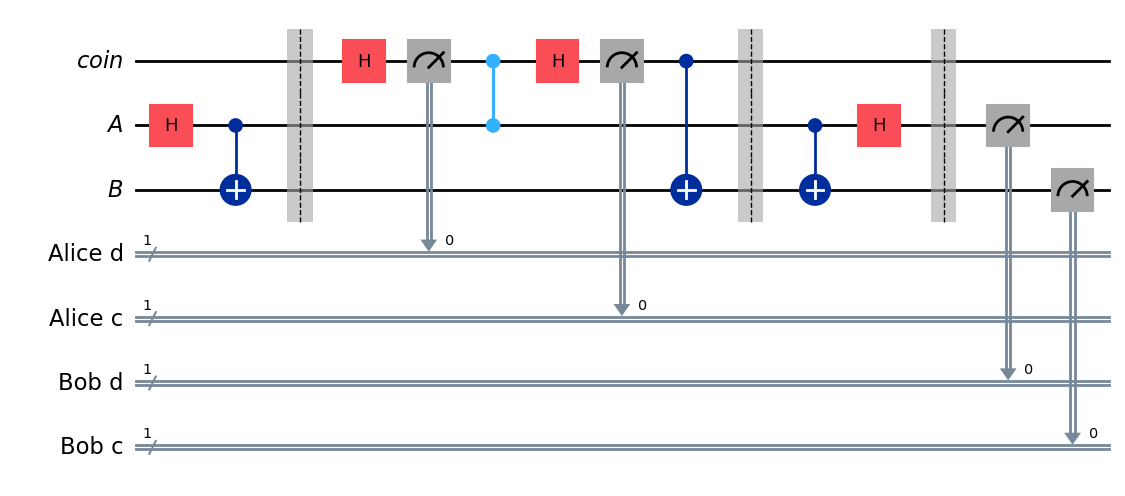

In [21]:
rbg = QuantumRegister(1, "coin")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")

Alice_c = ClassicalRegister(1, "Alice c")
Alice_d = ClassicalRegister(1, "Alice d")

test = QuantumCircuit(rbg, ebit0, ebit1, Alice_d, Alice_c)

# Initialize the ebit
test.h(ebit0)
test.cx(ebit0, ebit1)
test.barrier()

# Use the 'coin' qubit (twice) to generate Alice's bits c and d. Then, the protocol runs, 
# starting with Alice's actions, which depend on her bits.

test.h(rbg)
test.measure(rbg, Alice_d)
test.cz(rbg, ebit0) 

test.h(rbg)
test.measure(rbg, Alice_c)
test.cx(rbg, ebit1)
test.barrier()



# Bob's actions
test.cx(ebit0, ebit1)
test.h(ebit0)
test.barrier()

Bob_c = ClassicalRegister(1, "Bob c")
Bob_d = ClassicalRegister(1, "Bob d")
test.add_register(Bob_d)
test.add_register(Bob_c)
test.measure(ebit0, Bob_d)
test.measure(ebit1, Bob_c)

display(test.draw(output="mpl"))

Running the Aer simulator shows the results: Alice and Bob's classical bits always agree.

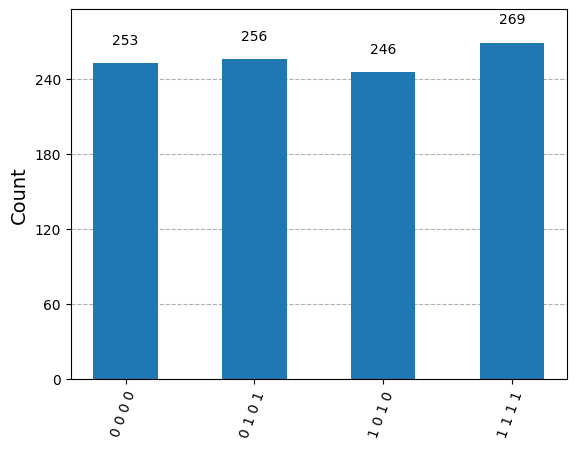

In [22]:
result = AerSimulator().run(test).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

# Tests with real hardware

In [23]:
%pip install uv --quiet
!uv pip install 'iqm-client[qiskit]==29.14' --quiet
%pip install lagrangeclient --index-url https://gitlab.linksfoundation.com/api/v4/projects/1709/packages/pypi/simple

Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://gitlab.linksfoundation.com/api/v4/projects/1709/packages/pypi/simple
Note: you may need to restart the kernel to use updated packages.


Let's get our token

In [24]:
!lagrangeclient

## On Windows
# import sys
# !{sys.executable} -m lagrangeclient

import json
with open('tokens.json', 'r') as f:
    config = json.load(f)
access_token = config['access_token']

== DEVICE LOGIN FLOW ==
🔗 Visit this URL in your browser:
https://spark.quantum.linksfoundation.com/auth/realms/cortex/device?user_code=BEWM-KSWA
Waiting for user to complete login...
=========== TOKEN ===========
eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJPN2g5cUtOOGRsdi1OZlo3Qm10NEJNZC0yaUFnMWt5STFEa2h0R3M5OU5rIn0.eyJleHAiOjE3NjE5MDA4OTAsImlhdCI6MTc2MTI5NjA5MCwiYXV0aF90aW1lIjoxNzYxMTM3NjY1LCJqdGkiOiJvbnJ0ZGc6ZTQ1ODNmMjUtNjNiZi02NGI0LTFkMGItYTJmOWU0MGZmZDUxIiwiaXNzIjoiaHR0cHM6Ly9zcGFyay5xdWFudHVtLmxpbmtzZm91bmRhdGlvbi5jb20vYXV0aC9yZWFsbXMvY29ydGV4IiwiYXVkIjoiYWNjb3VudCIsInN1YiI6IjRjZmJkMGZmLWEwMzktNGZhYS05NDc2LWVjMjFkNTgzZGQ5NSIsInR5cCI6IkJlYXJlciIsImF6cCI6ImlxbV9jbGllbnQiLCJzaWQiOiJhYThlMjVmOC1iNTY4LTQ2ZjgtYjcxNi1hOWMzZjNhODFmNGQiLCJhY3IiOiIwIiwiYWxsb3dlZC1vcmlnaW5zIjpbImh0dHBzOi8vc3BhcmsucXVhbnR1bS5saW5rc2ZvdW5kYXRpb24uY29tLyoiLCJodHRwczovL2lxbXNwYXJrLnBvbGl0by5pdC8iXSwicmVhbG1fYWNjZXNzIjp7InJvbGVzIjpbImV4YV9hZG1pbiIsIm9mZmxpbmVfYWNjZXNzIiwicGxhdGZvcm0tYWRtaW4iLCJjb3J0ZXhfYW

In [25]:
from iqm.qiskit_iqm import IQMProvider
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

provider = IQMProvider(url="https://spark.quantum.linksfoundation.com/station", token=access_token)
lagrange_backend = provider.get_backend()

pm = generate_preset_pass_manager(optimization_level=1, backend=lagrange_backend)
transpiled_circuit = pm.run(teleportation_test)

job = lagrange_backend.run(transpiled_circuit, shots=1024)

/Users/ema/miniconda3/envs/corso_qc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
station-control-client version '9.18.0' is newer minor version than '9.4.0' used by the station control server, some new client features might not be supported.


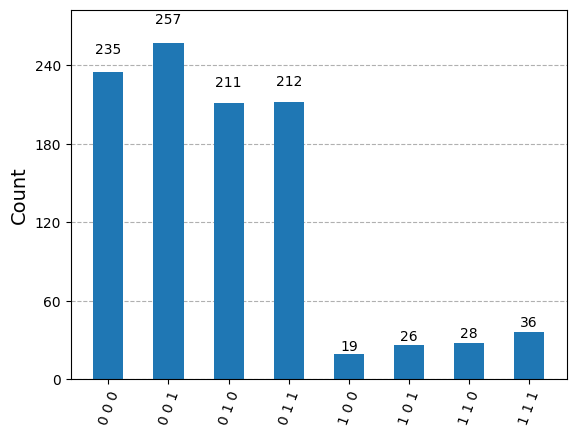

In [26]:
real_hw_statistics = job.result().get_counts()
display(plot_histogram(real_hw_statistics))

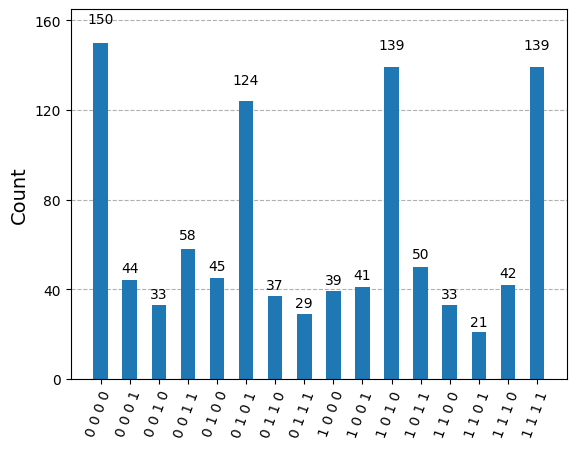

In [27]:
pm = generate_preset_pass_manager(optimization_level=1, backend=lagrange_backend)
transpiled_circuit = pm.run(test)

job = lagrange_backend.run(transpiled_circuit, shots=1024)

real_hw_statistics = job.result().get_counts()
display(plot_histogram(real_hw_statistics))